# Notebook 54: Initial X Final Mass Mapping

In [1]:
nb_id = 54

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.stats import linregress

import mesa_reader as mr
import mesaPlot as mp

import sys
sys.path.append('..')
from src.util import Z_SUN, savefig_base, DATA_ROOT, MESA_DATA_ROOT

plt.style.use('./plotstyle.mplstyle')

In [3]:
Z_SUN

0.017

In [4]:
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [5]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
        
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [6]:
def load_models(project_folder):
    model_folders = list(project_folder.glob('*_md*_m*_zsundiv*_*y0_*dy'))
    _model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
    model_dicts = dict()
    for dicts in _model_dicts:
        for m in dicts.keys():
            if m not in model_dicts.keys():
                model_dicts[m] = dicts[m]
    return model_dicts

## Data

In [7]:
project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4'
model_dicts_00005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/08_ZdivZsun_5d-3'
model_dicts_0005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/07_ZdivZsun_2d-2'
model_dicts_002zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/06_ZdivZsun_5d-2'
model_dicts_005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1'
model_dicts_01zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1'
model_dicts_02zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1'
model_dicts_04zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/03_ZdivZsun_6d-1'
model_dicts_06zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1'
model_dicts_08zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0'
model_dicts_10zsun = load_models(project_folder)


In [8]:
all_model_dicts = {
    '0.0005': model_dicts_00005zsun,
    '0.005': model_dicts_0005zsun,
    '0.02': model_dicts_002zsun,
    '0.05': model_dicts_005zsun,
    '0.1': model_dicts_01zsun,
    '0.2': model_dicts_02zsun,
    '0.4': model_dicts_04zsun,
    '0.6': model_dicts_06zsun,
    '0.8': model_dicts_08zsun,
    '1.0': model_dicts_10zsun
}

final_core_prop_array_dict = {
    '0.0005': np.load(DATA_ROOT/'09_enhanced_w_core_props.npy'),
    '0.005': np.load(DATA_ROOT/'08_enhanced_w_core_props.npy'),
    '0.02': np.load(DATA_ROOT/'07_enhanced_w_core_props.npy'),
    '0.05': np.load(DATA_ROOT/'06_enhanced_w_core_props.npy'),
    '0.1': np.load(DATA_ROOT/'00_enhanced_w_core_props.npy'),
    '0.2': np.load(DATA_ROOT/'01_enhanced_w_core_props.npy'),
    '0.4': np.load(DATA_ROOT/'02_enhanced_w_core_props.npy'),
    '0.6': np.load(DATA_ROOT/'03_enhanced_w_core_props.npy'),
    '0.8': np.load(DATA_ROOT/'04_enhanced_w_core_props.npy'),
    '1.0': np.load(DATA_ROOT/'05_enhanced_w_core_props.npy')
}

In [9]:
h = mr.MesaData(str(model_dicts_01zsun['300.0']['4.00']/'LOGS/history.data'))

In [10]:
def get_m_ht_het(h):
    m_i = h.star_mass[0]
    
    try:
        he_poor_end_i = np.where(h.surface_he4 >= 0.3)[0][0]
    except:
        return None, None, None, None
    
    try:
        he_rich_start_i = np.where(h.surface_he4 >= 0.7)[0][0]
    except IndexError:
        return None, None, None, None

    try:
        he_rich_end_i = np.where(((h.center_c12 < 1e-3)
                                & (h.center_he4 < 1e-2)
                                & (h.center_h1 < 0.5)))[0][0]
    except:
        try:
            he_rich_end_i = np.where(((h.center_c12 < 0.5)
                                & (h.center_he4 < 0.5)
                                & (h.center_h1 < 0.5)))[0][0]
        except:
            return None, None, None, None
   
    he_poor_end_t = h.star_age[he_poor_end_i]
    he_rich_end_t = h.star_age[he_rich_end_i]
    he_rich_start_t = h.star_age[he_rich_start_i]
    he_poor_dt = he_poor_end_t
    he_rich_dt = he_rich_end_t - he_rich_start_t
    m_f = h.star_mass[he_rich_end_i]
        
    return m_i, m_f, he_poor_dt, he_rich_dt

In [11]:
dict_ = all_model_dicts
z_keys = np.array(list(dict_.keys()))
z_keys = z_keys[z_keys.astype(float).argsort()]

dict_ = model_dicts_01zsun
m_keys = np.array(list(dict_.keys()))
m_keys = m_keys[m_keys.astype(float).argsort()]

dict_ = model_dicts_01zsun['300.0']
p_keys = np.array(list(dict_.keys()))
p_keys = p_keys[p_keys.astype(float).argsort()]

## Bulding models

Collect the duration of the He-poor and He-rich phases as a function on Mzams and Pzams from our MESA models.

In [ ]:
def get_m_dt_arr_singlez(model_dicts, m_keys, p_keys):
    m_dt_arr_singlez = np.zeros((len(m_keys), len(p_keys), 4))

    for i_m, m_key in enumerate(m_keys):
        print(f'Loading models for m = {m_key}')
        for i_p, p_key in enumerate(p_keys):
            model_folder = model_dicts[m_key][p_key]
            try:
                h = mr.MesaData(str(model_folder/'LOGS/history.data'))
            except:
                print(f'No history data for m = {m_key}, p = {p_key}')
                continue
            m_i, m_f, he_poor_dt, he_rich_dt = get_m_ht_het(h)
            if m_i is None:
                continue
            m_dt_arr_singlez[i_m, i_p] = [m_i, m_f, he_poor_dt, he_rich_dt]
            
    return m_dt_arr_singlez

def get_m_dt_arr(all_model_dicts, m_keys, p_keys):
    with ProcessPoolExecutor(max_workers=30) as executor:
        futures = {
            executor.submit(get_m_dt_arr_singlez, model_dicts, m_keys, p_keys): z_key
            for z_key, model_dicts in all_model_dicts.items()
        }
        
        unsorted_z_keys = []
        unsorted_z_arrs = []
        for future in as_completed(futures):
            unsorted_z_keys.append(futures[future])
            unsorted_z_arrs.append(future.result())
        sorted_z_arrs = [unsorted_z_arrs[i] for i in np.argsort(unsorted_z_keys)]
        
    m_dt_arr = np.array(sorted_z_arrs)
    return m_dt_arr

In [19]:
mdat_path = DATA_ROOT/'m_dt_arr.npy'
if mdat_path.exists():
    m_dt_arr = np.load(mdat_path)
else:
    m_dt_arr = get_m_dt_arr(all_model_dicts, m_keys, p_keys)
    np.save(mdat_path, m_dt_arr)

Text(0, 0.5, '$\\tau_\\mathrm{H}/\\mathrm{yr}$')

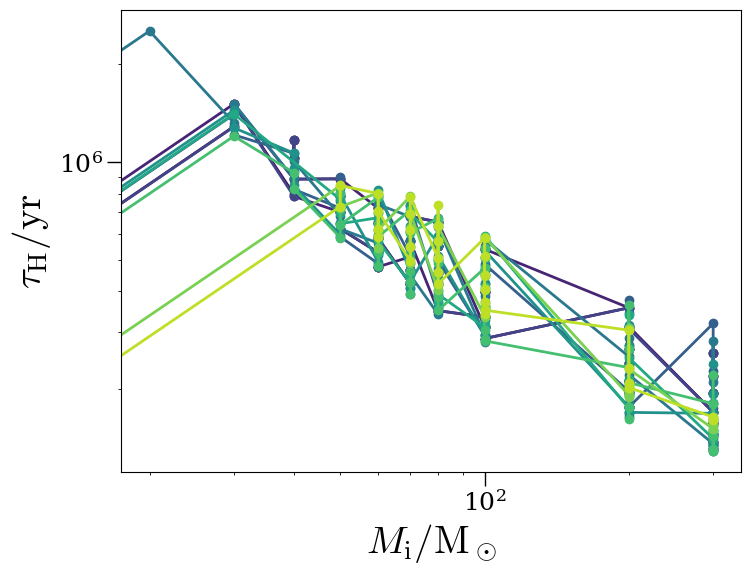

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = cm.viridis
for i_z, z_key in enumerate(z_keys):

    c = cmap(i_z / len(z_keys))
    m_dt_arr_singlez = m_dt_arr[i_z]
    m_dt_arr_singlez = m_dt_arr_singlez[~np.isnan(m_dt_arr_singlez).any(axis=2)]
    x = m_dt_arr_singlez[:, 0]
    y = m_dt_arr_singlez[:, 2]
    y = y[x.argsort()]
    x = x[x.argsort()]
    ax.plot(x, y, '-o', c=c)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$M_\mathrm{i}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\tau_\\mathrm{H}/\\mathrm{yr}$')

Text(0, 0.5, '$\\tau_\\mathrm{He}/\\mathrm{yr}$')

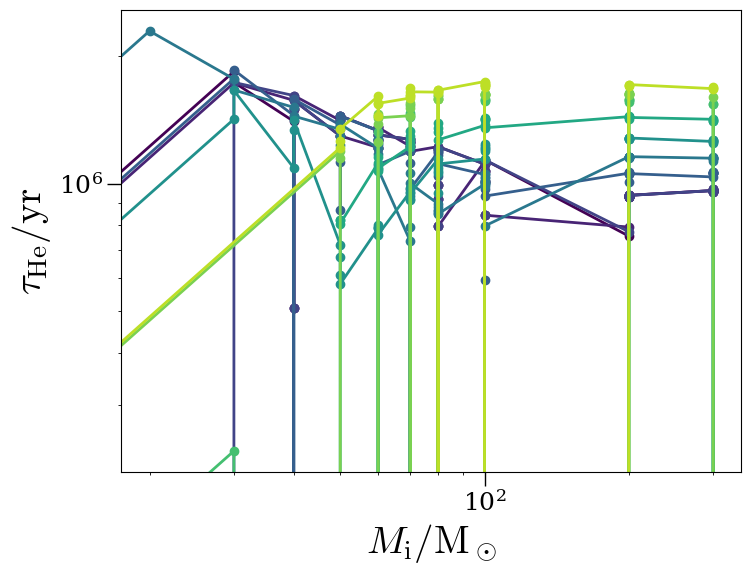

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = cm.viridis
for i_z, z_key in enumerate(z_keys):

    c = cmap(i_z / len(z_keys))
    m_dt_arr_singlez = m_dt_arr[i_z]
    m_dt_arr_singlez = m_dt_arr_singlez[~np.isnan(m_dt_arr_singlez).any(axis=2)]
    x = m_dt_arr_singlez[:, 0]
    y = m_dt_arr_singlez[:, 3]
    y = y[x.argsort()]
    x = x[x.argsort()]
    ax.plot(x, y, '-o', c=c)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$M_\mathrm{i}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\tau_\\mathrm{He}/\\mathrm{yr}$')

Approximate our He-poor and He-rich thick winds as power-laws over mass. For now we consider the mass loss from thin winds negligible.

In [31]:
def grafener_l_to_m_he_burning(l):
    """Equation 18 from Gräfener et al. (2011).
    
    From relations 17, 16 and 18 in Table A.1 Switch at logL=6.5 is from
    Sabhahit et al. (2023).
    """
    
    FF = [8.177, -1.0, 105.5, -10.10] # 18
    #FF = [3.997, -1.0, 25.83, -3.268] # 16
    #FF = [3.059, -1.0, 14.76, -2.049] # 17
    logm = FF[0] + FF[1] * np.sqrt(FF[2] + FF[3] * np.log10(l))
    return 10.**logm

pl_t = 1.41e5
pl_z = 10.**np.arange(-5, 1, 1) * Z_SUN
pl_l = np.logspace(3.8, 8, 10000)
pl_m = np.array([grafener_l_to_m_he_burning(l) for l in pl_l])


In [90]:
def edd_gamma(l, m, x):
    return 10**-4.817 * (1+x) * l/m


def sander2020_ge_w(g_e, z):
    g_eb = -0.324*np.log10(z/Z_SUN) + 0.244
    c = -0.44*np.log10(z/Z_SUN) + 9.15
    d = 0.23*np.log10(z/Z_SUN) - 2.61
    
    #print(g_eb, c, d, g_e, z)
    
    log_mdot = 2.932 * np.log10(-np.log10(1-g_e)) - np.log10(2) * (g_eb/g_e)**c + d
    #print(2.932 , np.log10(-np.log10(1-g_e)), np.log10(2), (g_eb/g_e), c, d)
    w = 10.**log_mdot
    #print(log_mdot)
    return w

def sander2023_ge_w(l, m, t_eff, z, x):
    g_e = edd_gamma(l, m, x)
    #print(g_e)
    w20 = sander2020_ge_w(g_e, z)
    #print(w20)
    if t_eff > 1.e5:
        log_mdot = np.log10(w20) - 6*np.log10(t_eff/1.41e5)
        w = 10.**log_mdot
    else:
        w = w20
    return w

@np.vectorize
def sander2023_l_w(l, t, z):
    logz = np.log10(z/Z_SUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1.41e5)
        w = 10.**log_w
    return w

def vink2017_w(l, z):
    log_mdot = -13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/Z_SUN)
    w = 10.**log_mdot
    return w


/tmp/ipykernel_2086287/2012806839.py:9: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(sander2023_l_w(pl_l, pl_t, z))


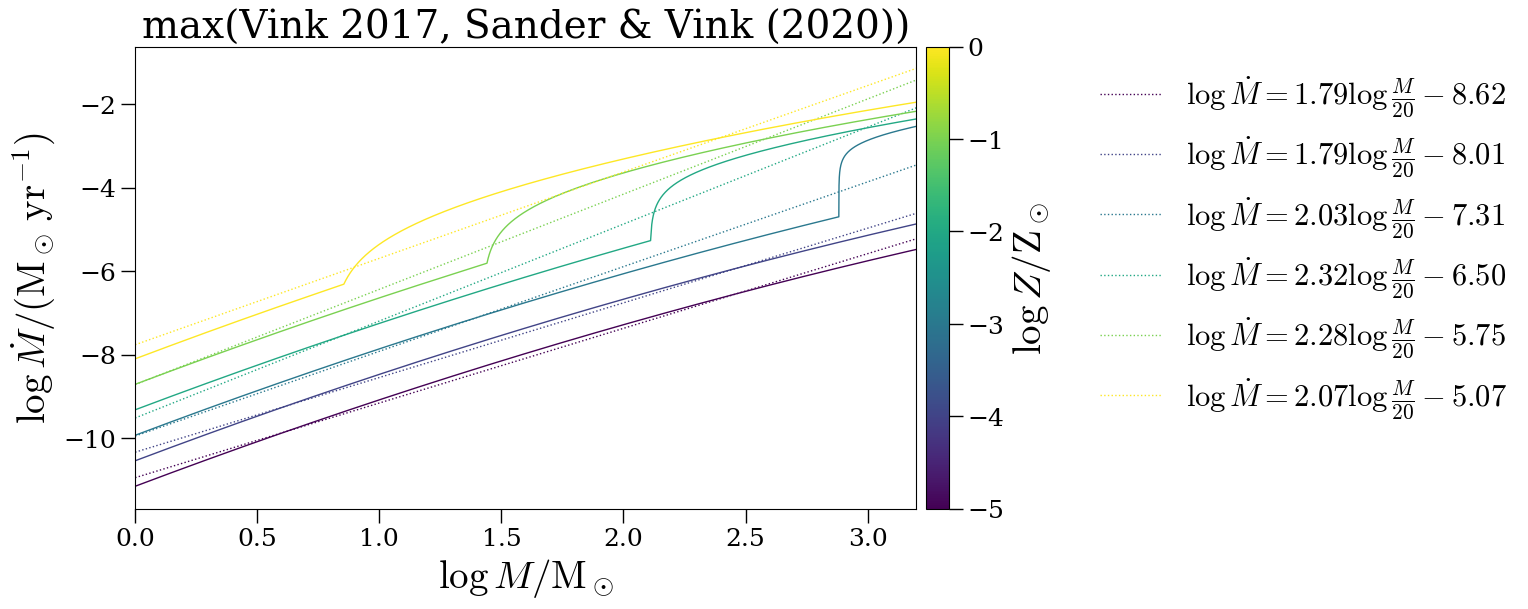

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))
cmap = cm.viridis

z_norm = np.zeros((len(pl_z), 2))
pl_fits = np.zeros((len(pl_z), 3))
x = np.log10(pl_m)
for i, z in enumerate(pl_z):
    c = cmap((np.log10(z/Z_SUN)+5)/5)
    y = np.log10(sander2023_l_w(pl_l, pl_t, z))
    y2 = np.log10(vink2017_w(pl_l, z))
    y3 = np.max([y, y2], axis=0)
    #ax.plot(x, y, '--', c=c, lw=0.5)
    #ax.plot(x, y2, '--', c=c, lw=0.5)
    ax.plot(x, y3, '-', c=c, lw=1)
    
    
    reg_x = x[~np.isinf(y3)] - np.log10(20)
    reg_y = y3[~np.isinf(y3)]
    slope, norm, *_ = linregress(np.copy(reg_x), np.copy(reg_y))
    ax.plot(x, norm+slope*(x-np.log10(20)), ':', c=c, lw=1, label=f'$\\log\dot{{M}}={slope:.2f}\\log \\frac{{M}}{{20}}{norm:.2f}$')   
    z_norm[i] = (np.log10(z/Z_SUN), norm)
    pl_fits[i] = [np.log10(z/Z_SUN), slope, norm]

ax.set_ylabel('$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')
ax.set_xlabel('$\\log M/\\mathrm{M}_\\odot$')

sm = cm.ScalarMappable(Normalize(vmin=-5, vmax=0), cmap=cmap)
cb = fig.colorbar(sm, ax=ax, pad=0.01)
cb.set_label('$\\log Z/\\mathrm{Z}_\\odot$')
ax.set_xlim(0, 3.2)
ax.set_title('max(Vink 2017, Sander & Vink (2020))')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.2, 1))

Text(0, 0.5, '$\\log \\dot{M}_{20}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

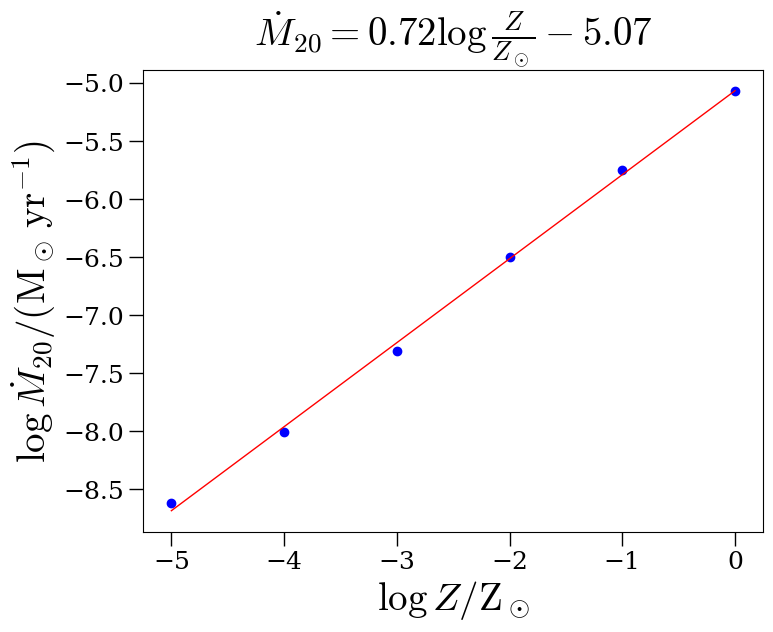

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))

slope, norm, *_ = linregress(pl_fits[:, 0], pl_fits[:, 2])
ax.plot(pl_fits[:, 0], pl_fits[:, 2], 'bo')
ax.plot(pl_fits[:, 0], norm+slope*pl_fits[:, 0], 'r-', lw=1, label=f'$\\log\dot{{M}}={slope:.2f}\\log \\frac{{M}}{{20}}{norm:.2f}$')
ax.set_title(f'$\dot{{M}}_{{20}}={slope:.2f}\\log\\frac{{Z}}{{Z_\\odot}} {norm:.2f}$')
ax.set_xlabel('$\\log Z/\\mathrm{Z}_\\odot$')
ax.set_ylabel('$\\log \\dot{M}_{20}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')




In [68]:
def krticka2024_w(l, teff, z):
    a = -13.82
    b = 1.52
    c = 3.84
    t1 = 14.16e3
    t2 = 37.9e3
    dt1 = 3.58e3
    dt2 = 56.5e3
    alpha = 0.358
    beta = -0.11
    delta = 0.73
    log_z_div_z_sun = np.log10(z/Z_SUN)
    
    log_lin_comp = (a
                    + alpha * log_z_div_z_sun
                    + (b + beta * log_z_div_z_sun) * np.log10(l/1e6))
    gauss_mix_comp = ((1 + delta * log_z_div_z_sun) * np.exp(-(teff-t1)**2/dt1**2)
                      + c * np.exp(-(teff-t2)**2/dt2**2))
    log_mdot = log_lin_comp - a * np.log10(gauss_mix_comp)
    w = 10.**log_mdot
    return w

In [128]:
from scipy.optimize import fmin

def grafener_m_to_l_he_burning(m):
    """Equation 10 from Gräfener et al. (2011).
    
    From relations 6, 7, and 8 in Table A.1 Switch at logL=6.5 is from
    Sabhahit et al. (2023).
    """
    #FF = [3.017, 2.446, -0.306] # 6
    #FF = [3.017, 2.446, -0.306] # 7
    FF = [3.826, 1.619, -0.099] # 8
    log_l = FF[0] + FF[1]*np.log10(m) + FF[2]*np.log10(m)**2
    return 10.**log_l

def l_div_m(l):
    m = grafener_l_to_m_he_burning(l)
    l_div_m = l/m
    return l_div_m

def g_e_to_l(g_e, x):
    l_div_m_ = (g_e / 10.**-4.817 / (1+x))
    l = fmin(lambda x: np.abs(l_div_m(x) - l_div_m_), 1e6, disp=False)
    return l

def sabhahit2023_g_switch_k24(z):
    g_switch = 0.701 * (z/Z_SUN)**-0.056
    return g_switch

@np.vectorize
def vink2011_w(m, t, z):
    l = grafener_m_to_l_he_burning(m)
    g_e = edd_gamma(l, m, 0.7)
    g_switch = sabhahit2023_g_switch_k24(z)
    
    if g_e < g_switch:
        w = krticka2024_w(l, t, z)
    else:
        l_switch = g_e_to_l(g_switch, 0.7)
        m_switch = grafener_l_to_m_he_burning(l_switch)
        mdot_switch = krticka2024_w(l_switch, t, z)
        w = mdot_switch * (l/l_switch)**4.77 * (m/m_switch)**-3.99
        
    return w
        

In [129]:
np.log10(g_e_to_l(0.6, 0.7))

/tmp/ipykernel_2086287/578971236.py:11: RuntimeWarning: invalid value encountered in log10
  logm = FF[0] + FF[1] * np.sqrt(FF[2] + FF[3] * np.log10(l))


array([5.41052322])

In [130]:
np.log10(g_e_to_l(sabhahit2023_g_switch_k24(0.017), 0.7)), grafener_l_to_m_he_burning(g_e_to_l(sabhahit2023_g_switch_k24(0.017), 0.7))

(array([5.64906436]), array([16.47385604]))

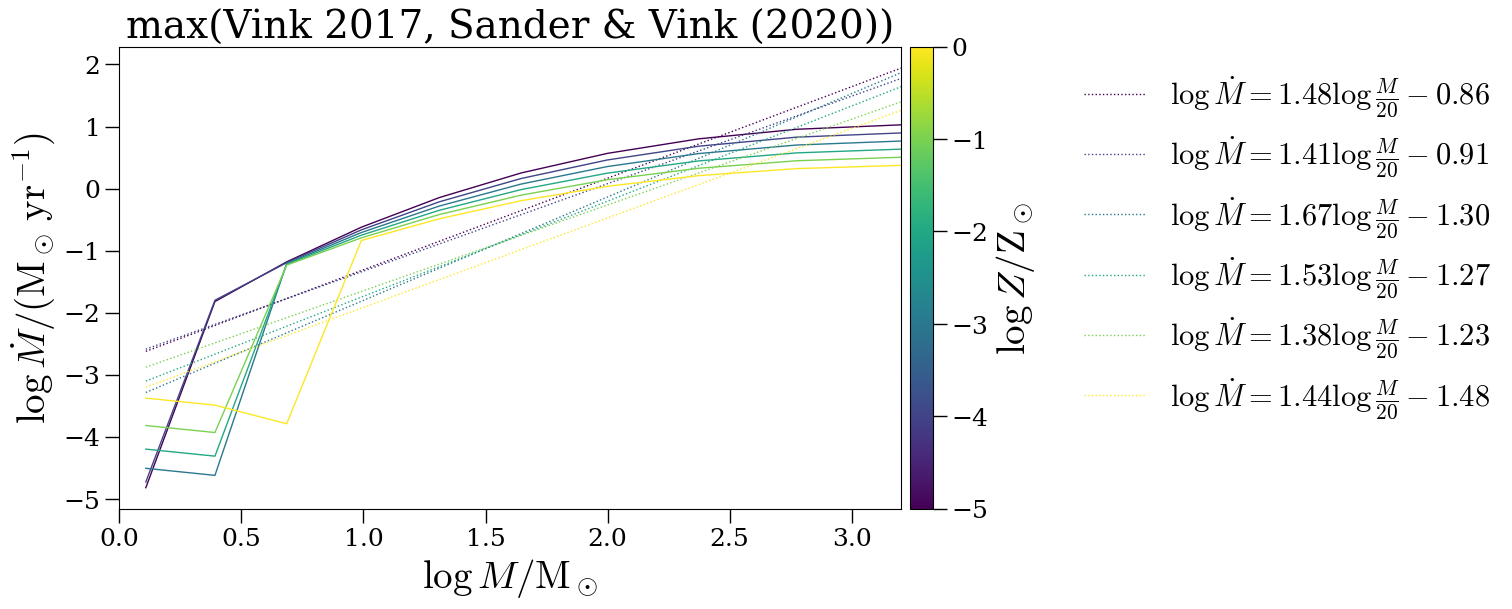

In [131]:
pl_t = 10.**4.75# 1.41e5
pl_z = 10.**np.arange(-5, 1, 1) * Z_SUN
pl_l = np.logspace(4, 8, 10)
pl_m = np.array([grafener_l_to_m_he_burning(l) for l in pl_l])

fig, ax = plt.subplots(figsize=(12, 6))
cmap = cm.viridis

z_norm = np.zeros((len(pl_z), 2))
pl_fits = np.zeros((len(pl_z), 3))
x = np.log10(pl_m)
for i, z in enumerate(pl_z):
    c = cmap((np.log10(z/Z_SUN)+5)/5)
    #y = np.log10(sander2023_l_w(pl_l, pl_t, z))
    #y2 = np.log10(vink2017_w(pl_l, z))
    y3 = np.log10(vink2011_w(pl_l, pl_t, z))
    #ax.plot(x, y, '--', c=c, lw=0.5)
    #ax.plot(x, y2, '--', c=c, lw=0.5)
    ax.plot(x, y3, '-', c=c, lw=1)
    
    
    reg_x = x[~np.isinf(y3)] - np.log10(20)
    reg_y = y3[~np.isinf(y3)]
    slope, norm, *_ = linregress(np.copy(reg_x), np.copy(reg_y))
    ax.plot(x, norm+slope*(x-np.log10(20)), ':', c=c, lw=1, label=f'$\\log\dot{{M}}={slope:.2f}\\log \\frac{{M}}{{20}}{norm:.2f}$')   
    z_norm[i] = (np.log10(z/Z_SUN), norm)
    pl_fits[i] = [np.log10(z/Z_SUN), slope, norm]

ax.set_ylabel('$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')
ax.set_xlabel('$\\log M/\\mathrm{M}_\\odot$')

sm = cm.ScalarMappable(Normalize(vmin=-5, vmax=0), cmap=cmap)
cb = fig.colorbar(sm, ax=ax, pad=0.01)
cb.set_label('$\\log Z/\\mathrm{Z}_\\odot$')
ax.set_xlim(0, 3.2)
ax.set_title('max(Vink 2017, Sander & Vink (2020))')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1.2, 1))

In [175]:
mr_hepoor = 10.**-6.5
beta_hepoor = 3.7
t20_hepoor = 10.**6.23
mr20_hepoor = mr_hepoor/(20/t20_hepoor)

mr_herich = 10.**-6.5
beta_herich = 2.3
t20_herich = 10.**6.23
mr20_herich = mr/(20/t20_herich)

In [176]:
def get_mf(mi_, mr20, t20, dt, beta):
    mi = mi_/20
    mf_power = mi**(1-beta) + (beta - 1) * mr20 * dt/t20
    mf = mf_power**(1/(1-beta))
    return mf*20

/tmp/ipykernel_2086287/3325793870.py:3: RuntimeWarning: divide by zero encountered in power
  mf_power = mi**(1-beta) + (beta - 1) * mr20 * dt/t20


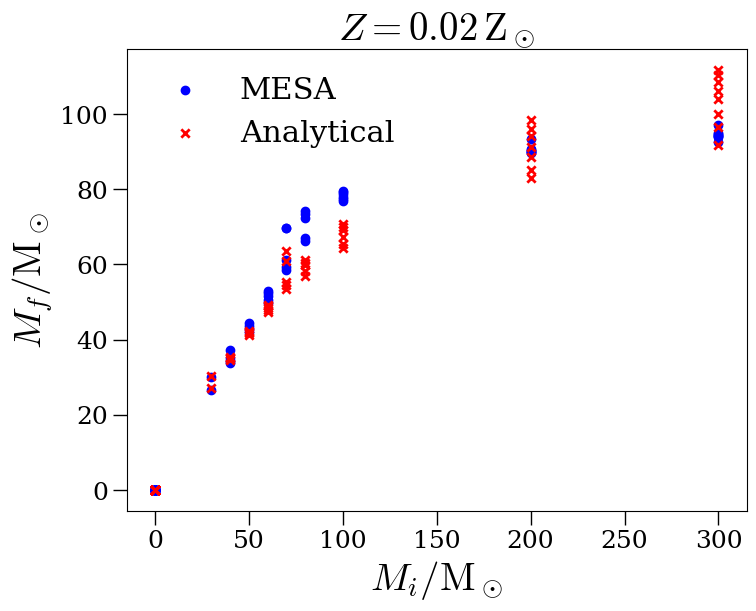

In [177]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = cm.viridis
for i_z, z_key in enumerate(z_keys):
    if z_key != '0.02':
        continue
    c = cmap(i_z / len(z_keys))
    m_dt_arr_singlez = m_dt_arr[i_z]
    m_dt_arr_singlez = m_dt_arr_singlez[~np.isnan(m_dt_arr_singlez).any(axis=2)]
    ax.scatter(m_dt_arr_singlez[:, 0], m_dt_arr_singlez[:, 1], c='b')
    ax.scatter(m_dt_arr_singlez[:, 0], get_mf(get_mf(m_dt_arr_singlez[:, 0], mr20_hepoor, t20_hepoor, m_dt_arr_singlez[:, 2], beta_hepoor), mr20_herich, t20_herich, m_dt_arr_singlez[:, 3], beta_herich), c='r', marker='x')
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.plot(np.linspace(20, 300, 100), get_mf(np.linspace(20, 300, 100), mr20, alpha, beta), 'r')

ax.set_xlabel('$M_i/\mathrm{M}_\odot$')
ax.set_ylabel('$M_f/\mathrm{M}_\odot$')
ax.set_title('$Z=0.02\,\mathrm{Z}_\odot$')

handles, labels = ax.get_legend_handles_labels()
handles.append(ax.scatter([], [], marker='o', c='b', label='MESA'))
handles.append(ax.scatter([], [], marker='x', c='r', label='Analytical'))
ax.legend(handles=handles, loc='upper left', frameon=False)

In [214]:
mr_hepoor = 10.**-6
beta_hepoor = 5
t20_hepoor = 10.**6.23
mr20_hepoor = mr_hepoor/(20/t20_hepoor)

mr_herich = 10.**-5.5
beta_herich = 2.3
t20_herich = 10.**6.23
mr20_herich = mr/(20/t20_herich)

/tmp/ipykernel_2086287/3325793870.py:3: RuntimeWarning: divide by zero encountered in power
  mf_power = mi**(1-beta) + (beta - 1) * mr20 * dt/t20


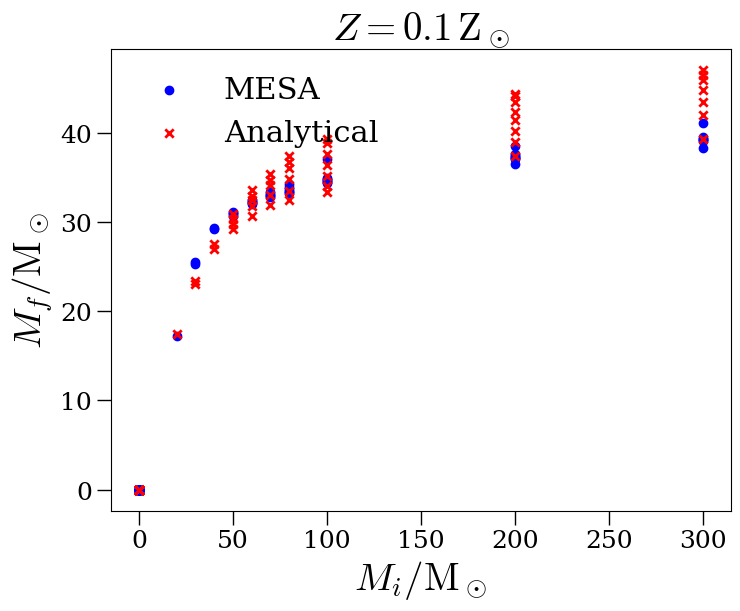

In [215]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = cm.viridis
for i_z, z_key in enumerate(z_keys):
    if z_key != '0.1':
        continue
    c = cmap(i_z / len(z_keys))
    m_dt_arr_singlez = m_dt_arr[i_z]
    m_dt_arr_singlez = m_dt_arr_singlez[~np.isnan(m_dt_arr_singlez).any(axis=2)]
    ax.scatter(m_dt_arr_singlez[:, 0], m_dt_arr_singlez[:, 1], c='b')
    ax.scatter(m_dt_arr_singlez[:, 0], get_mf(get_mf(m_dt_arr_singlez[:, 0], mr20_hepoor, t20_hepoor, m_dt_arr_singlez[:, 2], beta_hepoor), mr20_herich, t20_herich, m_dt_arr_singlez[:, 3], beta_herich), c='r', marker='x')
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.plot(np.linspace(20, 300, 100), get_mf(np.linspace(20, 300, 100), mr20, alpha, beta), 'r')

ax.set_xlabel('$M_i/\mathrm{M}_\odot$')
ax.set_ylabel('$M_f/\mathrm{M}_\odot$')
ax.set_title('$Z=0.1\,\mathrm{Z}_\odot$')

handles, labels = ax.get_legend_handles_labels()
handles.append(ax.scatter([], [], marker='o', c='b', label='MESA'))
handles.append(ax.scatter([], [], marker='x', c='r', label='Analytical'))
ax.legend(handles=handles, loc='upper left', frameon=False)

/tmp/ipykernel_2086287/3325793870.py:3: RuntimeWarning: divide by zero encountered in power
  mf_power = mi**(1-beta) + (beta - 1) * mr20 * dt/t20


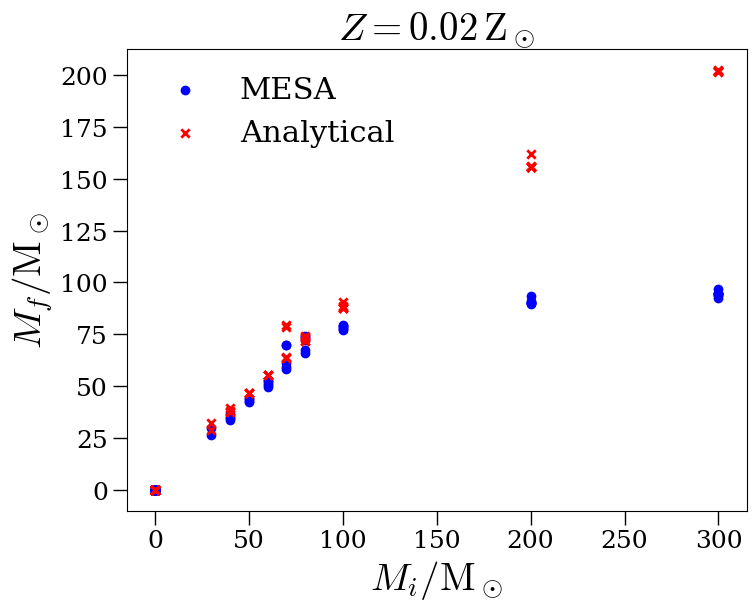

In [182]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = cm.viridis
for i_z, z_key in enumerate(z_keys):
    if z_key != '0.02':
        continue
    c = cmap(i_z / len(z_keys))
    m_dt_arr_singlez = m_dt_arr[i_z]
    m_dt_arr_singlez = m_dt_arr_singlez[~np.isnan(m_dt_arr_singlez).any(axis=2)]
    ax.scatter(m_dt_arr_singlez[:, 0], m_dt_arr_singlez[:, 1], c='b')
    ax.scatter(m_dt_arr_singlez[:, 0], get_mf(m_dt_arr_singlez[:, 0], mr20, t20, m_dt_arr_singlez[:, 3], beta), c='r', marker='x')
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.plot(np.linspace(20, 300, 100), get_mf(np.linspace(20, 300, 100), mr20, alpha, beta), 'r')

ax.set_xlabel('$M_i/\mathrm{M}_\odot$')
ax.set_ylabel('$M_f/\mathrm{M}_\odot$')
ax.set_title('$Z=0.02\,\mathrm{Z}_\odot$')

handles, labels = ax.get_legend_handles_labels()
handles.append(ax.scatter([], [], marker='o', c='b', label='MESA'))
handles.append(ax.scatter([], [], marker='x', c='r', label='Analytical'))
ax.legend(handles=handles, loc='upper left', frameon=False)